Notebook for plotting behavior before and after iso anesthesia.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    assert False, 'plot_dir not yet implemented on Nat laptop'
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Anesthesia import behavior

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [34]:
sesh_list = {"Kiwi": {"dir": Path("/data2/Anesthesia/Behavior_Rats/Kiwi/2025_04_16_AnesTrack2"),
                      "iso_end": pd.Timestamp(year=2025, month=4, day=16, hour=13, minute=25),
                      "rorr": pd.Timestamp(year=2025, month=4, day=16, hour=13, minute=33),
                      "track_start": pd.Timestamp(year=2025, month=4, day=16, hour=14, minute=14)}, 
             "Peach": {"dir": Path("/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2"),
                       "iso_end": pd.Timestamp(year=2025, month=4, day=17, hour=13, minute=18),
                       "rorr": pd.Timestamp(year=2025, month=4, day=17, hour=13, minute=23),
                       "track_start": pd.Timestamp(year=2025, month=4, day=17, hour=14, minute=10)}
            }

In [23]:
(lick_df["Datetime"] + pd.Timedelta(hours=12) - sesh_list["Kiwi"]["iso_end"]).dt.total_seconds()

0     46180.745
1     46938.488
2     46953.435
3     47890.264
4     47906.994
        ...    
80    50958.218
81    51061.219
82    51110.606
83    51300.324
84    51310.713
Name: Datetime, Length: 85, dtype: float64

In [44]:
(lick_df[lick_df.Trial == 40]["Datetime"].iloc[-1] - lick_df[lick_df.Trial == 0]["Datetime"]).dt.total_seconds() / 60

0    137.96665
Name: Datetime, dtype: float64

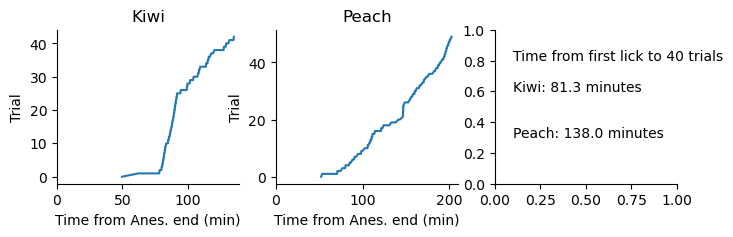

In [50]:
session = "Kiwi"

fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[2].text(0.1, 0.8, "Time from first lick to 40 trials")
for ida, (a, session) in enumerate(zip(ax, ["Kiwi", "Peach"])):
    perf_file = sorted(sesh_list[session]["dir"].glob("**/*Performance*.txt"))[0]
    lick_df = behavior.get_lick_data(perf_file)
    lick_df["Datetime"] = lick_df["Datetime"] + pd.Timedelta(hours=12)  # Time was recorded in 12 hr format w/o AM/PM
    lick_df["Time from Anes. end (min)"] = (lick_df["Datetime"] - sesh_list[session]["iso_end"]).dt.total_seconds() / 60
    
    
    sns.lineplot(data=lick_df[lick_df.Correct == 1], x="Time from Anes. end (min)", y="Trial", ax=a)
    a.set_title(session)
    a.set_xlim([0, a.get_xlim()[1]])

    time_to_40 = ((lick_df[lick_df.Trial == 40]["Datetime"].iloc[-1] - lick_df[lick_df.Trial == 0]["Datetime"]).dt.total_seconds() / 60).values[0]
    ax[2].text(0.1, 0.6 - ida*0.3, f"{session}: {time_to_40:.1f} minutes")

sns.despine(fig=fig)

fig.savefig(plot_dir / "Time_to_run_following_iso.pdf")